In [9]:
import pandas as pd

In [4]:
mlp = pd.read_csv("/project/genomics/xenofon/colab/SPEOS/tosave/results/centraldogma/highlevel/mtcentraldogma_mlp_eqtl_hpoea.tsv", sep="\t", header=0, index_col=0)
tag = pd.read_csv("/project/genomics/xenofon/colab/SPEOS/tosave/results/centraldogma/highlevel/mtcentraldogma_tag_eqtl_hpoea.tsv", sep="\t", header=0, index_col=0)

In [5]:
merged = mlp.join(tag, lsuffix="_mlp", rsuffix="_tag", how="inner").sort_values(by="fdr_q_value_tag")
merged_top = merged.head(10)

In [8]:

# in case you have speos installed, import image settings:
from speos.visualization.settings import *
# else uncomment the following: 
#import matplotlib as mpl
#full_width = 18
#cm = 1/2.54
#small_font = 6
#medium_font = 8
#large_font = 10
#mpl.rc('xtick', labelsize=small_font)
#mpl.rc('ytick', labelsize=small_font)
#mpl.rcParams['axes.linewidth'] = 0.4
#mpl.rcParams['ytick.major.size'] = 3
#mpl.rcParams['ytick.major.width'] = 0.5
#mpl.rcParams['ytick.minor.size'] = 2
#mpl.rcParams['ytick.minor.width'] = 0.3
#mpl.rcParams['xtick.major.size'] = 2
#mpl.rcParams['xtick.major.width'] = 0.3
#mpl.rcParams['xtick.minor.size'] = 1
#mpl.rcParams['xtick.minor.width'] = 0.1

import matplotlib.pyplot as plt


def colorFader(c1="#000000", c2="#ffffff", mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    import matplotlib as mpl
    import numpy as np
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

def get_gradient(value, min, max, gradients):
    normalized_value = (value - min) / (max - min) 
    return gradients[0][int(normalized_value * 100)]

def plot_enrichment(merged_df, base_color:str ="#600F5C"):
    import numpy as np
    import textwrap
    import matplotlib as mpl

    color_gradients = []
    for colors in [base_color]:
        color_gradients.append({x: colorFader(c1 = colors, mix = ((100-x)/100) * 0.85 ) for x in range(101)})

    max_enrichment = max(merged_top["enrichment_mlp"].max(), merged_top["enrichment_tag"].max())
    min_enrichment = min(merged_top["enrichment_mlp"].min(), merged_top["enrichment_tag"].min())

    plt.rcParams['text.usetex'] = False

    fig, ax = plt.subplots(1, 1, figsize=(full_width*cm*0.25, 10*cm))


    y = np.arange(len(merged_df))[::-1]
    offset = 0.2
    width = 0.35

    colors = [get_gradient(value, min_enrichment, max_enrichment, color_gradients) for value in merged_top["enrichment_tag"]]
    values = merged_top["log_q_tag"]

    ax.barh(y=y+offset, height=width, width=values, color=colors, edgecolor="black", linewidth=0.5)

    colors = [get_gradient(value, min_enrichment, max_enrichment, color_gradients) for value in merged_top["enrichment_mlp"]]
    values = merged_top["log_q_mlp"]

    ax.barh(y=y-offset, height=width, width=values, color=colors)
    ax.set_xlabel("-log(FDR)", fontsize=medium_font)
    ax.set_yticks(y)
    ax.set_yticklabels([textwrap.fill(e, 23) for e in merged_top["description_mlp"]])

    cmap = mpl.colors.ListedColormap(color_gradients[0].values())

    norm = mpl.colors.Normalize(vmin=1, vmax=max_enrichment)

    cmappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(cmappable,
                                    ax=ax,
                                    #label=,
                                    ticks=range(1,19,2),
                                    pad=0.00,
                                    location="top")
    cbar.set_label("Fold Enrichment", fontsize=medium_font)

    return fig, ax


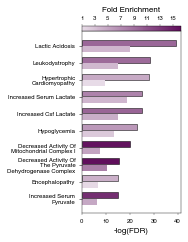

In [7]:
fig, ax = plot_enrichment(merged_df=merged_top)

plt.savefig("enrichment_gnn_vs_mlp_hpoea_mtcentraldogma.svg", bbox_inches="tight", dpi=450)


## sort the other way around

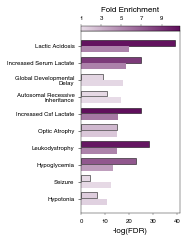

In [16]:
merged = mlp.join(tag, lsuffix="_mlp", rsuffix="_tag", how="inner").sort_values(by="fdr_q_value_mlp")
merged_top = merged.head(10)
fig, ax = plot_enrichment(merged_df=merged_top)

# getting all at once

In [29]:
# big loopy loop
for geneset in ["centraldogma", "dynamics", "metabolism", "oxphos", "proteinimport", "signaling", "smols"]:
    for onthology in ["hpoea", "goea_biological_process", "pathwayea"]:
        mlp = pd.read_csv("/project/genomics/xenofon/colab/SPEOS/tosave/results/{}/highlevel/mt{}_mlp_eqtl_{}.tsv".format(geneset, geneset, onthology), sep="\t", header=0, index_col=0)
        tag = pd.read_csv("/project/genomics/xenofon/colab/SPEOS/tosave/results/{}/highlevel/mt{}_tag_eqtl_{}.tsv".format(geneset, geneset, onthology), sep="\t", header=0, index_col=0)

        merged = mlp.join(tag, lsuffix="_mlp", rsuffix="_tag", how="inner").sort_values(by="fdr_q_value_tag")
        if len(merged) > 0:
            merged_top = merged.head(10)
            fig, ax = plot_enrichment(merged_df=merged_top)

            plt.savefig("../plots/merged/enrichment_gnn_vs_mlp_{}_{}_sort_gnn.svg".format(geneset, onthology), bbox_inches="tight", dpi=450)

            merged = mlp.join(tag, lsuffix="_mlp", rsuffix="_tag", how="inner").sort_values(by="fdr_q_value_mlp")
            merged_top = merged.head(10)
            fig, ax = plot_enrichment(merged_df=merged_top)
            plt.savefig("../plots/merged/enrichment_gnn_vs_mlp_{}_{}_sort_mlp.svg".format(geneset, onthology), bbox_inches="tight", dpi=450)
            
        else:
            continue

        plt.close("all")

In [6]:

def get_gradient(value, min, max, gradients):
    normalized_value = (value - min) / (max - min) 
    return gradients[0][int(normalized_value * 100)]

def plot_enrichment(merged_df, base_color:str ="#600F5C"):
    import numpy as np
    import textwrap
    import matplotlib as mpl

    color_gradients = []
    for colors in [base_color]:
        color_gradients.append({x: colorFader(c1 = colors, mix = ((100-x)/100) * 0.85 ) for x in range(101)})

    max_enrichment = max(merged_top["log_q_mlp"].max(), merged_top["log_q_tag"].max())
    min_enrichment = min(merged_top["log_q_mlp"].min(), merged_top["log_q_tag"].min())

    plt.rcParams['text.usetex'] = False

    fig, ax = plt.subplots(1, 1, figsize=(full_width*cm*0.25, 10*cm))


    y = np.arange(len(merged_df))[::-1]
    offset = 0.2
    width = 0.35

    colors = [get_gradient(value, min_enrichment, max_enrichment, color_gradients) for value in merged_top["log_q_tag"]]
    values = merged_top["enrichment_tag"]

    ax.barh(y=y+offset, height=width, width=values, color=colors, edgecolor="black", linewidth=0.5)

    colors = [get_gradient(value, min_enrichment, max_enrichment, color_gradients) for value in merged_top["log_q_mlp"]]
    values = merged_top["enrichment_mlp"]

    ax.barh(y=y-offset, height=width, width=values, color=colors)
    ax.set_xlabel("Fold Enrichment", fontsize=medium_font)
    ax.set_yticks(y)
    ax.set_yticklabels([textwrap.fill(e, 23) for e in merged_top["description_mlp"]])

    cmap = mpl.colors.ListedColormap(color_gradients[0].values())

    norm = mpl.colors.Normalize(vmin=1, vmax=max_enrichment)

    cmappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(cmappable,
                                    ax=ax,
                                    #label=,
                                    ticks=range(1,19,2),
                                    pad=0.00,
                                    location="top")
    cbar.set_label("-log(FDR)", fontsize=medium_font)

    return fig, ax

In [24]:
# big loopy loop
for geneset in ["centraldogma", "dynamics", "metabolism", "oxphos", "proteinimport", "signaling", "smols"]:
    for onthology in ["hpoea", "goea_biological_process", "pathwayea"]:
        mlp = pd.read_csv("/project/genomics/xenofon/colab/SPEOS/tosave/results/{}/highlevel/mt{}_mlp_eqtl_{}.tsv".format(geneset, geneset, onthology), sep="\t", header=0, index_col=0)
        tag = pd.read_csv("/project/genomics/xenofon/colab/SPEOS/tosave/results/{}/highlevel/mt{}_tag_eqtl_{}.tsv".format(geneset, geneset, onthology), sep="\t", header=0, index_col=0)

        merged = mlp.join(tag, lsuffix="_mlp", rsuffix="_tag", how="inner").sort_values(by="enrichment_tag", ascending=False)
        if len(merged) > 0:
            merged_top = merged.head(10)
            fig, ax = plot_enrichment(merged_df=merged_top)

            plt.savefig("../plots/merged/enrichment_by_fold_gnn_vs_mlp_{}_{}_sort_gnn.svg".format(geneset, onthology), bbox_inches="tight", dpi=450)

            merged = mlp.join(tag, lsuffix="_mlp", rsuffix="_tag", how="inner").sort_values(by="enrichment_mlp", ascending=False)
            merged_top = merged.head(10)
            fig, ax = plot_enrichment(merged_df=merged_top)
            plt.savefig("../plots/merged/enrichment_by_fold_gnn_vs_mlp_{}_{}_sort_mlp.svg".format(geneset, onthology), bbox_inches="tight", dpi=450)
            
        else:
            continue

        plt.close("all")

# allow non-significant terms

In [22]:
# big loopy loop
import numpy as np
for geneset in ["centraldogma", "dynamics", "metabolism", "oxphos", "proteinimport", "signaling", "smols"]:
    for onthology in ["hpoea", "goea_biological_process", "pathwayea"]:
         mlp = pd.read_csv("/project/genomics/xenofon/colab/SPEOS/tosave/results/{}/highlevel/mt{}_mlp_eqtl_{}.tsv".format(geneset, geneset, onthology), sep="\t", header=0, index_col=0)
        tag = pd.read_csv("/project/genomics/xenofon/colab/SPEOS/tosave/results/{}/highlevel/mt{}_tag_eqtl_{}.tsv".format(geneset, geneset, onthology), sep="\t", header=0, index_col=0)

        merged = mlp.join(tag, lsuffix="_mlp", rsuffix="_tag", how="outer")
        merged.enrichment_tag = merged.enrichment_tag.fillna(1)
        merged.enrichment_mlp = merged.enrichment_mlp.fillna(1)
        merged.log_q_mlp = merged.log_q_mlp.fillna(0)
        merged.log_q_tag = merged.log_q_tag.fillna(0)
        merged.description_mlp[merged.description_mlp.isna()] = merged.description_tag[merged.description_mlp.isna()]
        merged = merged.sort_values(by="enrichment_tag", ascending=False)
        merged.replace([np.inf, -np.inf], 100, inplace=True)
        if len(merged) > 0:
            merged_top = merged.head(10)
            fig, ax = plot_enrichment(merged_df=merged_top)

            plt.savefig("../plots/merged/enrichment_by_fold_gnn_vs_mlp_{}_{}_sort_gnn_outer.svg".format(geneset, onthology), bbox_inches="tight", dpi=450)

            merged = mlp.join(tag, lsuffix="_mlp", rsuffix="_tag", how="outer")
            merged.enrichment_tag = merged.enrichment_tag.fillna(1)
            merged.enrichment_mlp = merged.enrichment_mlp.fillna(1)
            merged.log_q_mlp = merged.log_q_mlp.fillna(0)
            merged.log_q_tag = merged.log_q_tag.fillna(0)
            merged.description_mlp[merged.description_mlp.isna()] = merged.description_tag[merged.description_mlp.isna()]
            merged = merged.sort_values(by="enrichment_mlp", ascending=False)
            merged_top = merged.head(10)
            fig, ax = plot_enrichment(merged_df=merged_top)
            plt.savefig("../plots/merged/enrichment_by_fold_gnn_vs_mlp_{}_{}_sort_mlp_outer.svg".format(geneset, onthology), bbox_inches="tight", dpi=450)
            
        else:
            continue

        plt.close("all")

/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# get stats

In [12]:
import json
for geneset in ["centraldogma", "dynamics", "metabolism", "oxphos", "proteinimport", "signaling", "smols"]:
    with open("/project/genomics/xenofon/colab/SPEOS/tosave/results/{}/highlevel/mt{}_mlp_eqtlouter_results.json".format(geneset, geneset), "r") as file:
        mlp = set(json.load(file)[0].keys())
    with open("/project/genomics/xenofon/colab/SPEOS/tosave/results/{}/highlevel/mt{}_tag_eqtlouter_results.json".format(geneset, geneset), "r") as file:
        tag = set(json.load(file)[0].keys())

    print(geneset)
    print("MLP: {} candidates".format(len(mlp)))
    print("GNN: {} candidates".format(len(tag)))
    print("Overlap Coefficient: {}".format( len(mlp.intersection(tag)) / min(len(mlp), len(tag))))
    print("")

centraldogma
MLP: 1035 candidates
GNN: 613 candidates
Overlap Coefficient: 0.6411092985318108

dynamics
MLP: 2567 candidates
GNN: 1441 candidates
Overlap Coefficient: 0.7779319916724496

metabolism
MLP: 1496 candidates
GNN: 1397 candidates
Overlap Coefficient: 0.6113099498926271

oxphos
MLP: 1274 candidates
GNN: 261 candidates
Overlap Coefficient: 0.42528735632183906

proteinimport
MLP: 425 candidates
GNN: 528 candidates
Overlap Coefficient: 0.20705882352941177

signaling
MLP: 1895 candidates
GNN: 1308 candidates
Overlap Coefficient: 0.8853211009174312

smols
MLP: 2680 candidates
GNN: 2664 candidates
Overlap Coefficient: 0.3322072072072072

